# Gunjan Chakraborty

# USN: 22MSRDS007

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.stats import skew, kurtosis, ttest_ind
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import PowerTransformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


### Load the Wholesale Customers dataset

In [2]:
data = pd.read_csv('D:/Chools/Day_07/Wholesale customers data.csv')

In [3]:
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [5]:
data.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

### Cheecking VIF

In [6]:
def calculate_vif(data):
    # Standardize the features as VIF is scale-dependent
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    # Calculate VIF for each variable
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data_scaled, i) for i in range(data_scaled.shape[1])]
    
    return vif_data

In [7]:
vif_result = calculate_vif(data)

# Display the VIF results
print(vif_result)

           Variable       VIF
0           Channel  1.791911
1            Region  1.014571
2             Fresh  1.206674
3              Milk  2.566544
4           Grocery  8.844377
5            Frozen  1.353524
6  Detergents_Paper  8.379030
7        Delicassen  1.524167


### Removing High VIF columns

In [8]:
# Identify the variable with the highest VIF
max_vif_variable = vif_result.loc[vif_result['VIF'].idxmax(), 'Variable']

# Remove the variable with the highest VIF
data_for_clustering_reduced = data.drop(columns=[max_vif_variable])

# Recalculate VIF
vif_result_reduced = calculate_vif(data_for_clustering_reduced)

# Display the updated VIF results
print(vif_result_reduced)

           Variable       VIF
0           Channel  1.781887
1            Region  1.014488
2             Fresh  1.192690
3              Milk  2.394623
4            Frozen  1.352167
5  Detergents_Paper  2.556897
6        Delicassen  1.472675


### Drop non-numeric columns like 'Channel' and 'Region' 

In [9]:
# Drop non-numeric columns like 'Channel' and 'Region' 
data = data.drop(['Channel', 'Region'], axis=1)

### Standardize the data

In [10]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

### Apply DBSCAN

In [11]:
epsilon = 0.5
min_samples = 5

dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(data_scaled)

In [12]:
# Add the cluster labels to the original dataset
data['Cluster'] = clusters

### Remove outliers

In [13]:
data_no_outliers = data[data['Cluster'] != -1]

In [14]:
# Evaluate cluster quality using silhouette score and Davies-Bouldin index
silhouette_avg = silhouette_score(data_no_outliers.drop('Cluster', axis=1), data_no_outliers['Cluster'])
db_index = davies_bouldin_score(data_no_outliers.drop('Cluster', axis=1), data_no_outliers['Cluster'])

print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Index: {db_index}")

Silhouette Score: 0.6427298710188302
Davies-Bouldin Index: 0.3104995963254223


### Vizualizations and analysis

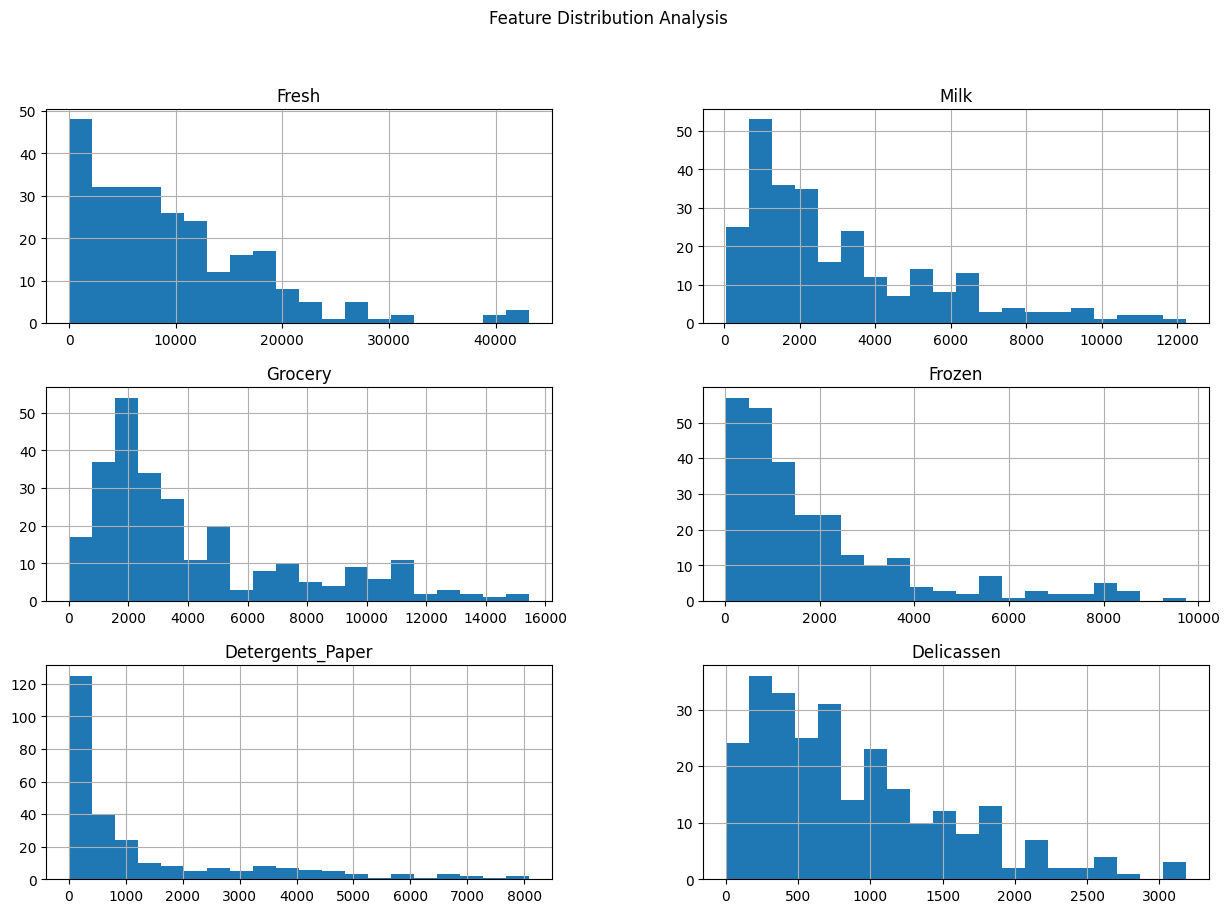

In [15]:
# 1. Feature Distribution Analysis
# Visualize the distribution of each feature using histograms or kernel density plots
data_no_outliers.drop('Cluster', axis=1).hist(bins=20, figsize=(15, 10))
plt.suptitle('Feature Distribution Analysis')
plt.show()

In [16]:
# Examine the skewness and kurtosis of the features
skewness = data_no_outliers.drop('Cluster', axis=1).apply(skew)
kurt = data_no_outliers.drop('Cluster', axis=1).apply(kurtosis)
print("Skewness:\n", skewness)
print("\nKurtosis:\n", kurt)

Skewness:
 Fresh               1.443952
Milk                1.310362
Grocery             1.207508
Frozen              1.752774
Detergents_Paper    1.821128
Delicassen          1.037327
dtype: float64

Kurtosis:
 Fresh               2.825377
Milk                1.250683
Grocery             0.523571
Frozen              2.718603
Detergents_Paper    2.592911
Delicassen          0.694544
dtype: float64


In [17]:
# Consider applying transformations (e.g., log transformations) to make the data more normally distributed
power_transformer = PowerTransformer()
data_transformed = power_transformer.fit_transform(data_no_outliers.drop('Cluster', axis=1))

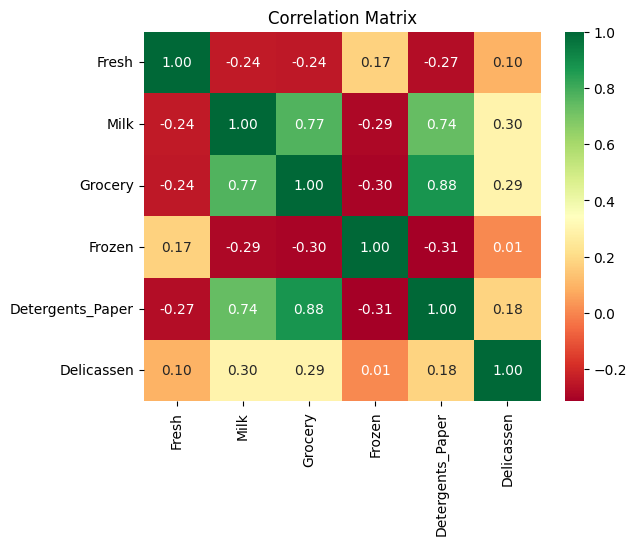

In [18]:
# 2. Correlation Analysis
# Compute and visualize the correlation matrix between features
corr_matrix = data_no_outliers.drop('Cluster', axis=1).corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [19]:
# Identify highly correlated features
highly_correlated_features = np.where(np.abs(corr_matrix) > 0.8)
correlated_pairs = [(corr_matrix.index[i], corr_matrix.columns[j]) for i, j in zip(*highly_correlated_features) if i != j]
print("Highly Correlated Feature Pairs:", correlated_pairs)

Highly Correlated Feature Pairs: [('Grocery', 'Detergents_Paper'), ('Detergents_Paper', 'Grocery')]


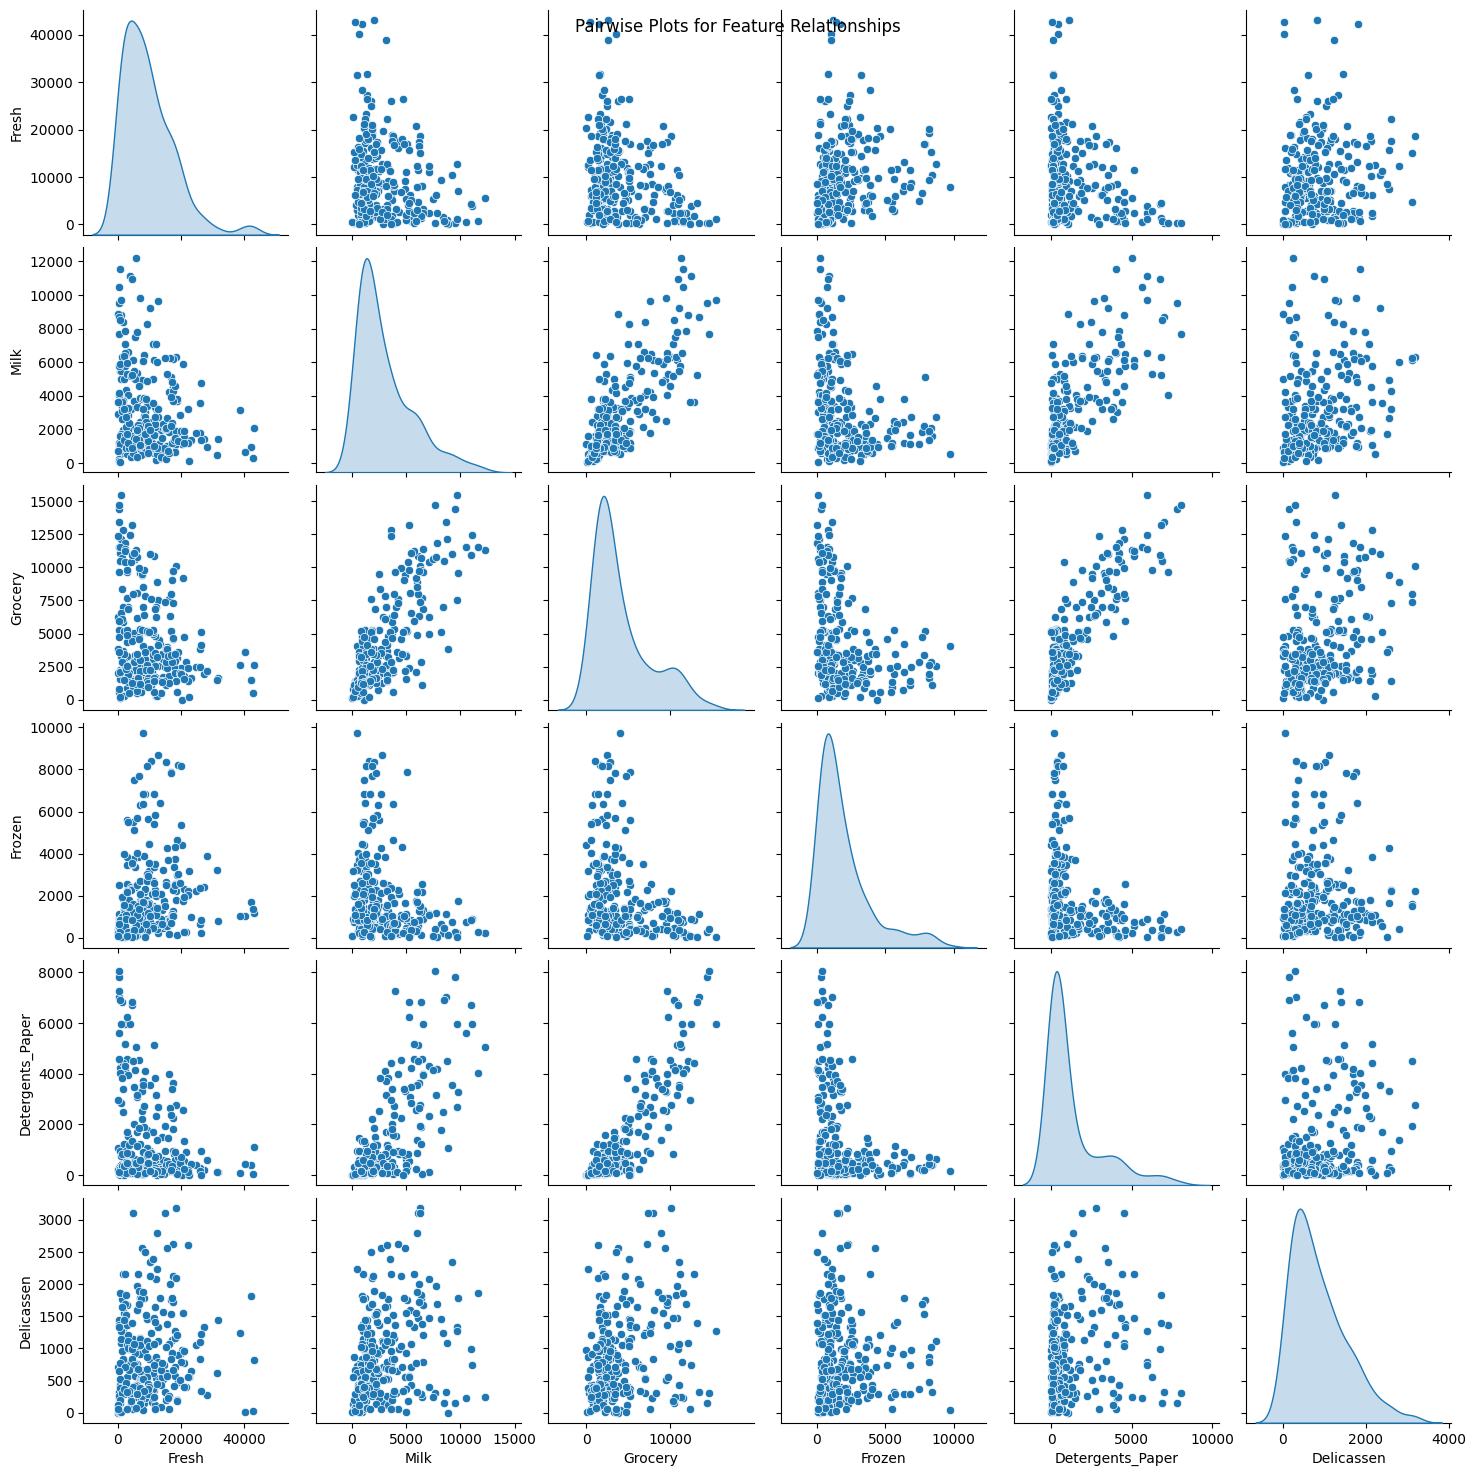

In [20]:
# 3. Pairwise Plots
# Create pairwise scatter plots for multiple features
sns.pairplot(data_no_outliers.drop('Cluster', axis=1), diag_kind='kde')
plt.suptitle('Pairwise Plots for Feature Relationships')
plt.show()

In [21]:
# 4. Statistical Tests
# Perform statistical tests (e.g., t-tests, ANOVA) to assess the significance of differences between clusters
# Example: T-test between Cluster 0 and Cluster 1 for the 'Milk' feature
cluster_0_milk = data_no_outliers[data_no_outliers['Cluster'] == 0]['Milk']
cluster_1_milk = data_no_outliers[data_no_outliers['Cluster'] == 1]['Milk']
t_stat, p_value = ttest_ind(cluster_0_milk, cluster_1_milk)
print(f"T-statistic: {t_stat}, p-value: {p_value}")

T-statistic: 1.4519521642928193, p-value: 0.14770227229666238


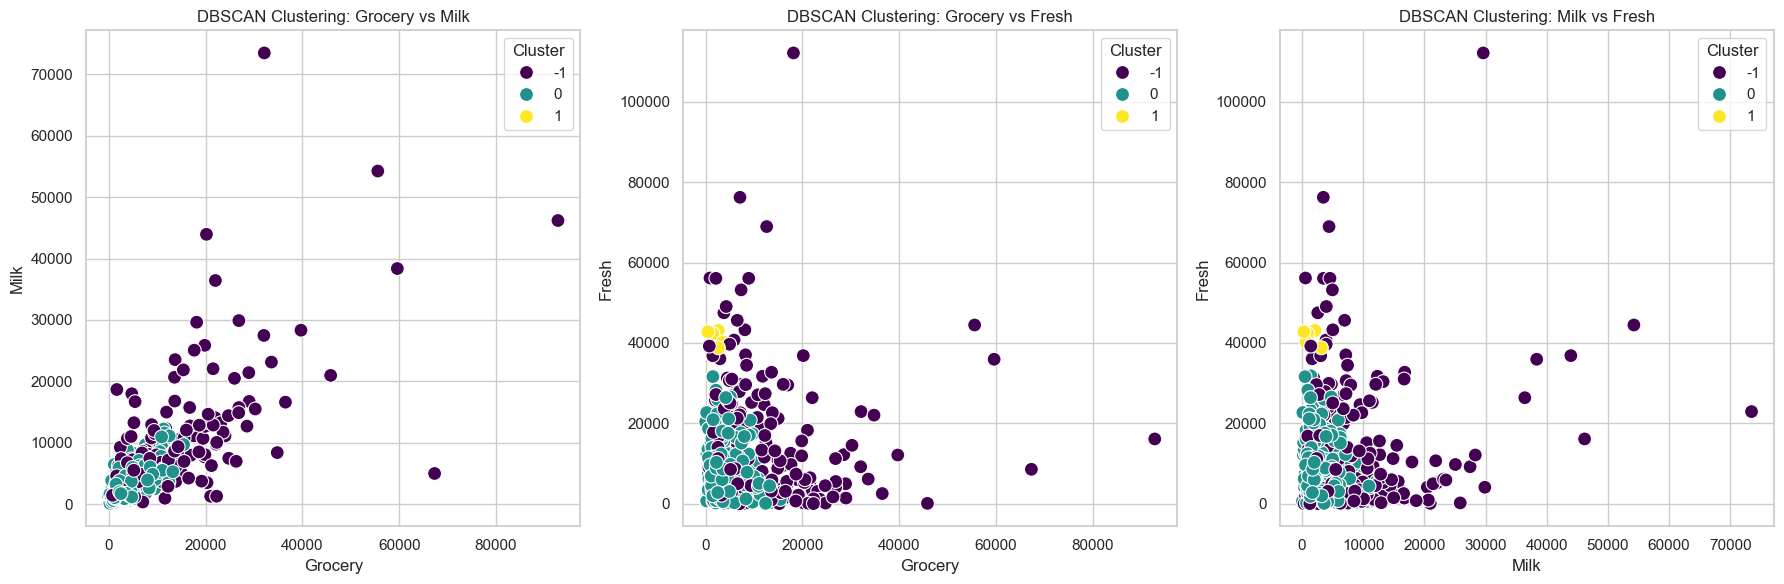

In [22]:
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# List of features for combinations
feature_combinations = [('Grocery', 'Milk'), ('Grocery', 'Fresh'), ('Milk', 'Fresh')]

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(feature_combinations), figsize=(18, 6))

# Visualize the clusters for each feature combination
for i, (feature_x, feature_y) in enumerate(feature_combinations):
    sns.scatterplot(x=feature_x, y=feature_y, hue='Cluster', data=data, palette='viridis', s=100, ax=axes[i])
    axes[i].set_title(f'DBSCAN Clustering: {feature_x} vs {feature_y}')
    axes[i].set_xlabel(feature_x)
    axes[i].set_ylabel(feature_y)

plt.tight_layout()
plt.show()


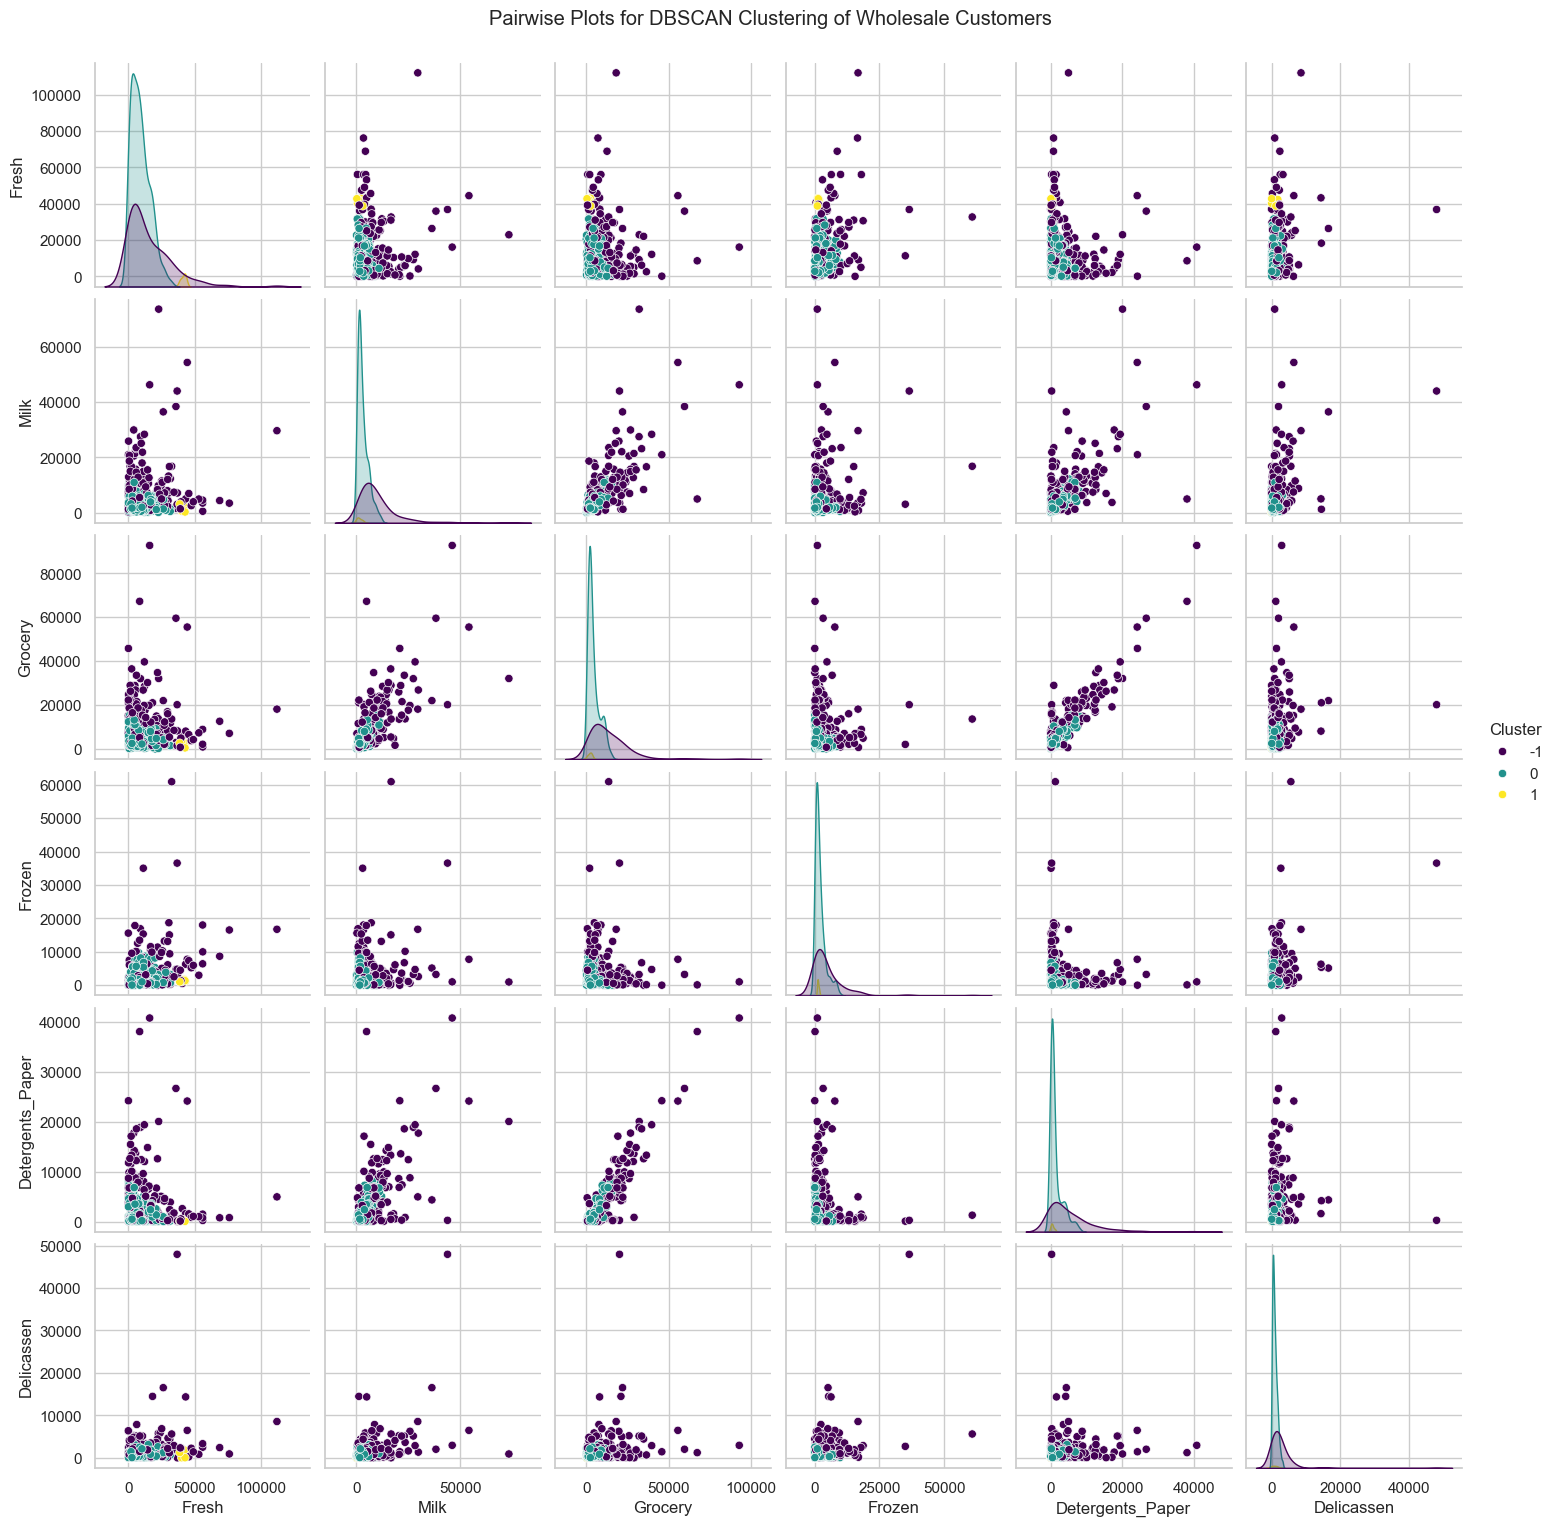

In [23]:
# Set style
sns.set(style="whitegrid")

# Select numerical columns for visualization
numerical_columns = data.drop(['Cluster'], axis=1).columns

# Visualize all combinations of features
sns.pairplot(data, hue='Cluster', palette='viridis', vars=numerical_columns, diag_kind='kde', height=2.5)
plt.suptitle('Pairwise Plots for DBSCAN Clustering of Wholesale Customers', y=1.02)
plt.show()


### Interpretation of results


Cluster 0:

Number of data points: 261

Average spending in each category:
Fresh               9030.398467
Milk                3077.318008
Grocery             4234.061303
Frozen              1963.432950
Detergents_Paper    1322.134100
Delicassen           881.773946
dtype: float64


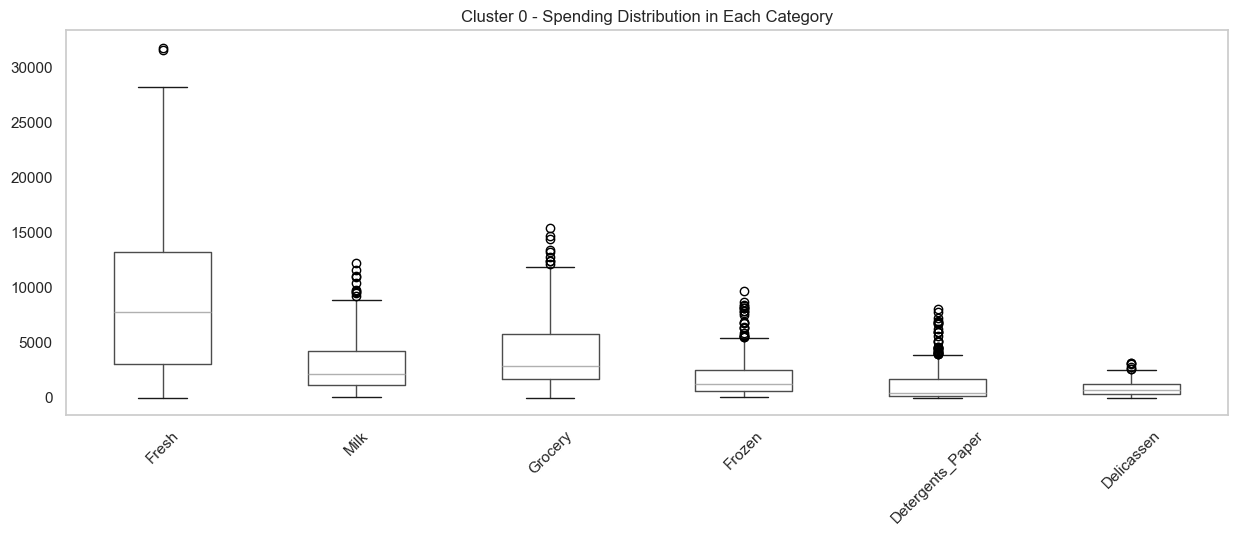


Cluster 1:

Number of data points: 5

Average spending in each category:
Fresh               41446.6
Milk                 1421.2
Grocery              2167.6
Frozen               1276.4
Detergents_Paper      416.2
Delicassen            784.8
dtype: float64


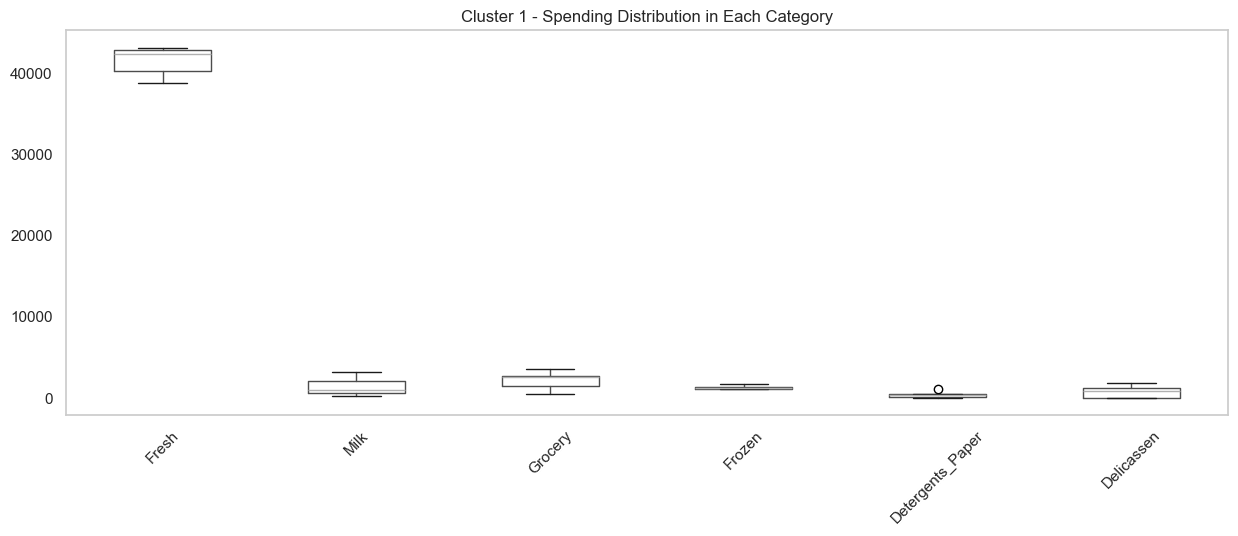

In [24]:
unique_clusters_no_outliers = data_no_outliers['Cluster'].unique()

for cluster in unique_clusters_no_outliers:
    print(f'\nCluster {cluster}:\n')

    cluster_data = data_no_outliers[data_no_outliers['Cluster'] == cluster]

    # Number of data points in the cluster
    num_points = len(cluster_data)
    print(f'Number of data points: {num_points}')

    # Average spending in each category
    avg_spending = cluster_data.drop('Cluster', axis=1).mean()
    print(f'\nAverage spending in each category:\n{avg_spending}')

    # Visualize the distribution of spending in each category
    cluster_data.drop('Cluster', axis=1).boxplot(grid=False, rot=45, figsize=(15, 5))
    plt.title(f'Cluster {cluster} - Spending Distribution in Each Category')
    plt.show()
